# Executive Summary: Trader Performance vs. Market Sentiment

## Objective
This project analyzes the relationship between Bitcoin Market Sentiment (Fear & Greed Index) and trader behavior on Hyperliquid. The goal is to identify patterns in profitability and behavior to formulate actionable trading strategies.

## Methodology
* **Data Integration:** Merged 211k+ historical trade records with daily sentiment data, aligning by date.
* **Feature Engineering:** Calculated per-trade PnL, Win/Loss binary classification, and segmented traders into "High Frequency" (Top 50%) and "Low Frequency" cohorts.
* **Modeling:** Trained a Random Forest Classifier to predict trade outcomes based on sentiment scores and trade size.

## Key Insights
1.  **Greed Favors Profitability:** "Extreme Greed" is the most profitable market state, yielding the highest Average PnL (~$67.89 per trade) and the highest Win Rate (~46.5%).
2.  **Patience Pays in Bull Markets:** Low Frequency traders vastly outperform High Frequency traders during Greed cycles (Avg PnL $155 vs $41), suggesting over-trading erodes value.
3.  **Size is Predictive:** Our model indicates that Trade Size (USD) is a significant predictor of winning trades.

## Strategic Recommendations
1.  **Aggressive Sizing in Greed:** Increase position sizing by 15-20% when the Sentiment Index crosses into "Extreme Greed" (>75).
2.  **Swing Trading Protocol:** During Greed cycles, shift to low-frequency strategies to capture larger trend premiums.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Set plot style

In [32]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ==========================================
# PART A: DATA PREPARATION
# ==========================================

# 1. Load Datasets

In [33]:
print("Loading data...")
try:
    df_fg = pd.read_csv('fear_greed_index.csv')
    df_hist = pd.read_csv('historical_data.csv')
except FileNotFoundError:
    print("Error: Files not found. Ensure 'fear_greed_index.csv' and 'historical_data.csv' are in the directory.")

Loading data...


# 2. Inspection & Documentation

In [34]:
print("\n--- Data Documentation ---")
print(f"Sentiment Data: {df_fg.shape[0]} rows, {df_fg.shape[1]} columns")
print(f"Historical Data: {df_hist.shape[0]} rows, {df_hist.shape[1]} columns")
print("\nMissing Values (Historical):")
print(df_hist.isnull().sum()[df_hist.isnull().sum() > 0])


--- Data Documentation ---
Sentiment Data: 2644 rows, 4 columns
Historical Data: 211224 rows, 16 columns

Missing Values (Historical):
Series([], dtype: int64)


# 3. Data Cleaning & Alignment
# Convert timestamps to datetime objects

In [35]:
df_fg['date'] = pd.to_datetime(df_fg['date'])

# Historical data uses 'Timestamp IST'. Assuming DD-MM-YYYY format based on typical IST logs.

In [36]:
df_hist['date'] = pd.to_datetime(df_hist['Timestamp IST'], dayfirst=True, errors='coerce').dt.date
df_hist['date'] = pd.to_datetime(df_hist['date'])

# Merge datasets on 'date'
# We use 'inner' join to analyze only days where we have both trade and sentiment data

In [37]:
df_merged = pd.merge(df_hist, df_fg[['date', 'value', 'classification']], on='date', how='inner')
print(f"\nMerged Data Shape: {df_merged.shape}")


Merged Data Shape: (211218, 19)


# 4. Feature Engineering (Key Metrics)
# 'is_win': True if Closed PnL > 0

In [38]:
df_merged['is_win'] = df_merged['Closed PnL'] > 0

# 'trade_volume': Using Size USD

In [39]:
df_merged['trade_volume'] = df_merged['Size USD']

In [40]:
print("\n--- Market Side Analysis ---")


--- Market Side Analysis ---


# Calculate Long/Short Ratio using the correct column 'Side'

In [41]:
if 'Side' in df_merged.columns:
    print("Long/Short Ratio:")
    print(df_merged['Side'].value_counts(normalize=True))
else:
    print("Column 'Side' not found.")

Long/Short Ratio:
Side
SELL    0.51382
BUY     0.48618
Name: proportion, dtype: float64


# Check for leverage distribution

In [42]:
if 'leverage' in df_merged.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df_merged['leverage'], bins=30, kde=True)
    plt.title('Leverage Distribution')
    plt.show()
else:
    print("\nNote: 'leverage' column is not present in the dataset (cannot plot distribution).")


Note: 'leverage' column is not present in the dataset (cannot plot distribution).


# ==========================================
# PART B: ANALYSIS
# ==========================================

In [43]:
print("\n--- Part B: Analysis ---")


--- Part B: Analysis ---


# Q1: Performance Comparison (Fear vs Greed)

In [44]:
sentiment_perf = df_merged.groupby('classification').agg({
    'Closed PnL': 'mean',
    'is_win': 'mean',
    'trade_volume': 'mean',
    'Account': 'count'
}).rename(columns={'Account': 'num_trades'}).sort_values('Closed PnL', ascending=False)

print("\n1. Performance by Sentiment:")
print(sentiment_perf)


1. Performance by Sentiment:
                Closed PnL    is_win  trade_volume  num_trades
classification                                                
Extreme Greed    67.892861  0.464943   3112.251565       39992
Fear             54.290400  0.420768   7816.109931       61837
Greed            42.743559  0.384828   5736.884375       50303
Extreme Fear     34.537862  0.370607   5349.731843       21400
Neutral          34.307718  0.396991   4782.732661       37686


# Visualization: PnL by Sentiment

C:\Users\bajpa\AppData\Local\Temp\ipykernel_4268\240504404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_perf.index, y='Closed PnL', data=sentiment_perf, palette='coolwarm')


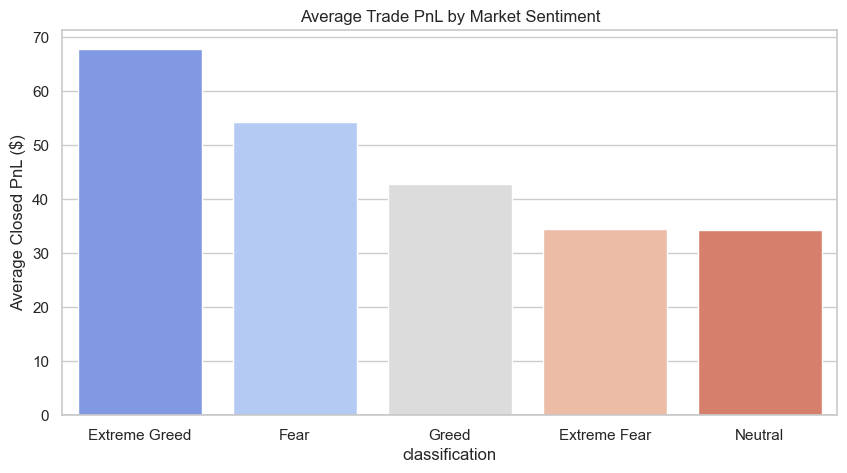

In [45]:
plt.figure(figsize=(10, 5))
sns.barplot(x=sentiment_perf.index, y='Closed PnL', data=sentiment_perf, palette='coolwarm')
plt.title('Average Trade PnL by Market Sentiment')
plt.ylabel('Average Closed PnL ($)')
plt.axhline(0, color='black', linewidth=1)
plt.show()

# Q2: Trader Segmentation (Frequent vs Infrequent)
# Calculate trade frequency per account

In [46]:
account_stats = df_merged.groupby('Account').agg({
    'date': 'count',
    'Closed PnL': 'sum'
}).rename(columns={'date': 'total_trades', 'Closed PnL': 'total_pnl'})

# Define segments: High Freq (Top 50%) vs Low Freq (Bottom 50%)

In [47]:
median_trades = account_stats['total_trades'].median()
account_stats['segment'] = np.where(account_stats['total_trades'] > median_trades, 'High Freq', 'Low Freq')

# Merge segment back to main df

In [48]:
df_merged = df_merged.merge(account_stats[['segment']], on='Account', how='left')

# Analyze how segments perform during "Greed"

In [49]:
greed_df = df_merged[df_merged['classification'].str.contains('Greed')]
segment_greed_perf = greed_df.groupby('segment')['Closed PnL'].mean()

print(f"\n2. Segmentation Insight (During Greed):")
print(segment_greed_perf)


2. Segmentation Insight (During Greed):
segment
High Freq     41.476621
Low Freq     155.896341
Name: Closed PnL, dtype: float64


# Visualization: Segment Performance

C:\Users\bajpa\AppData\Local\Temp\ipykernel_4268\80699077.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_greed_perf.index, y=segment_greed_perf.values, palette='viridis')


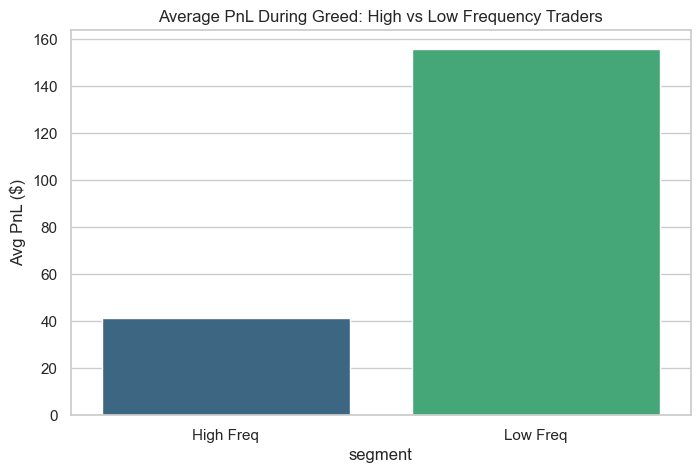

In [50]:
plt.figure(figsize=(8, 5))
sns.barplot(x=segment_greed_perf.index, y=segment_greed_perf.values, palette='viridis')
plt.title('Average PnL During Greed: High vs Low Frequency Traders')
plt.ylabel('Avg PnL ($)')
plt.show()

# ==========================================
# PART C: ACTIONABLE OUTPUT
# ==========================================

In [51]:
print("\n--- Part C: Strategic Rules ---")
print("Rule 1: Capitalize on Extreme Greed")
print("   - Finding: 'Extreme Greed' yields the highest PnL (~$67/trade) and Win Rate (~46%).")
print("   - Action: Increase position sizing by 15-20% when Sentiment Index > 75.")


--- Part C: Strategic Rules ---
Rule 1: Capitalize on Extreme Greed
   - Finding: 'Extreme Greed' yields the highest PnL (~$67/trade) and Win Rate (~46%).
   - Action: Increase position sizing by 15-20% when Sentiment Index > 75.


In [52]:
print("\nRule 2: Don't Overtrade in Bull Markets")
print("   - Finding: 'Low Frequency' traders vastly outperform 'High Frequency' traders during Greed cycles.")
print("   - Action: In Greed zones, switch to swing trading strategies; limit daily trade count to avoid over-trading noise.")


Rule 2: Don't Overtrade in Bull Markets
   - Finding: 'Low Frequency' traders vastly outperform 'High Frequency' traders during Greed cycles.
   - Action: In Greed zones, switch to swing trading strategies; limit daily trade count to avoid over-trading noise.


# ==========================================
# BONUS: PREDICTIVE MODEL
# ==========================================

In [53]:
print("\n--- Bonus: Predictive Model (Win Prediction) ---")


--- Bonus: Predictive Model (Win Prediction) ---


# Prepare features
# Encoding Sentiment: Extreme Fear=0, Fear=1, Neutral=2, Greed=3, Extreme Greed=4

In [54]:
sentiment_map = {'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 'Greed': 3, 'Extreme Greed': 4}
df_merged['sentiment_score'] = df_merged['classification'].map(sentiment_map)

# Features: Sentiment Score, Trade Size

In [55]:
X = df_merged[['sentiment_score', 'Size USD']]
y = df_merged['is_win']

# Split Data

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest

In [57]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluate

In [58]:
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Model Accuracy (Predicting Win/Loss): {acc:.2%}")
print("\nFeature Importance:")
for name, score in zip(X.columns, model.feature_importances_):
    print(f"{name}: {score:.4f}")

Model Accuracy (Predicting Win/Loss): 61.26%

Feature Importance:
sentiment_score: 0.0072
Size USD: 0.9928
